# XAI for the Random Forest Regressor 

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import shap
from sklearn.model_selection import train_test_split
import pandas as pd
import joblib 
import matplotlib.pyplot as plt
import warnings


from faa_p2.config import CLEAN_DATA_FILE, MODELS, RANDOM_STATE, DATA_SPLIT_RATIO, RFR, SAMPLE_IND
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load and split the data.

In [18]:
df = pd.read_csv(CLEAN_DATA_FILE, index_col=0)

y = df["medv"]
x = df.drop(columns=["medv"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=DATA_SPLIT_RATIO, random_state=RANDOM_STATE
)

Load the saved `RandomForestRegressor` model. More details on the parameters of the model are available in the [`modeling\02_random_forest.ipynb`](modeling\02_random_forest.ipynb) notebook.

In [19]:
# model 
config = MODELS[RFR]
model = joblib.load(config["filename"])
pred = model.predict(x_test)

## SHAP

In [20]:
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
shap_values = explainer(x_test)

### Global Interpretability

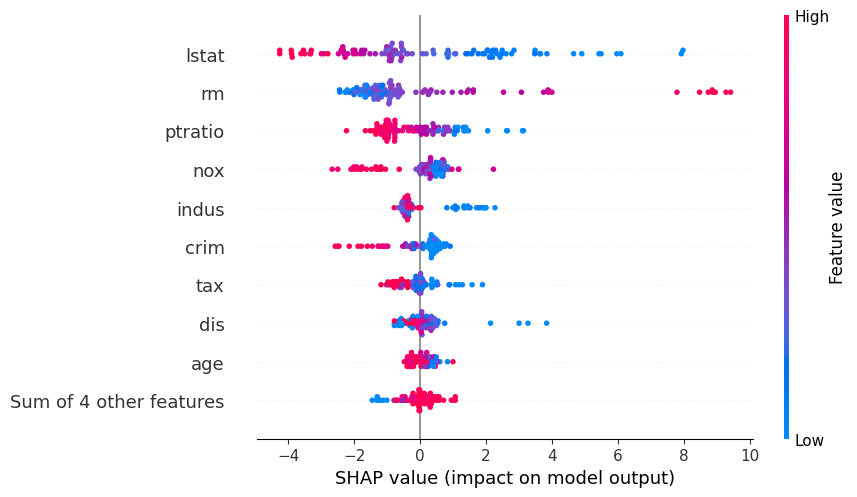

In [21]:
shap.plots.beeswarm(shap_values)

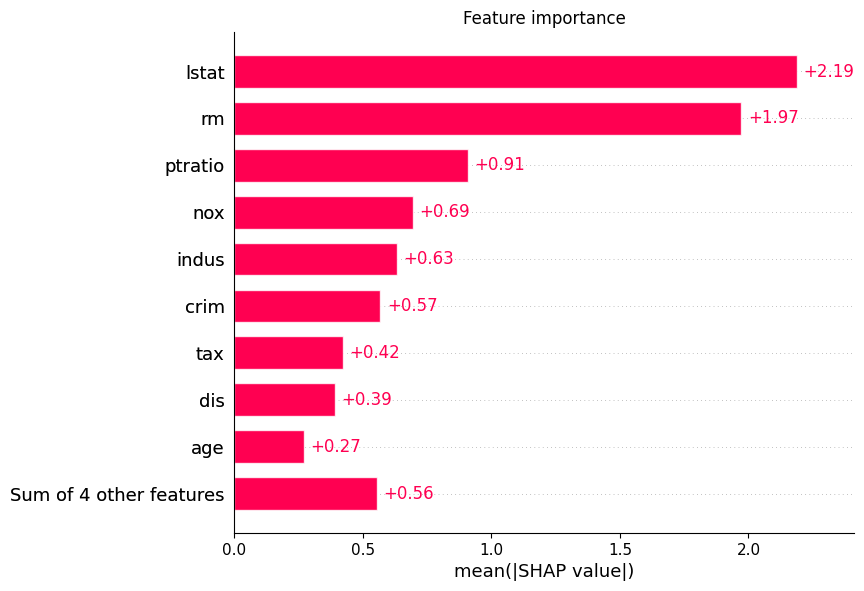

In [22]:
plt.title("Feature importance")
shap.plots.bar(shap_values)

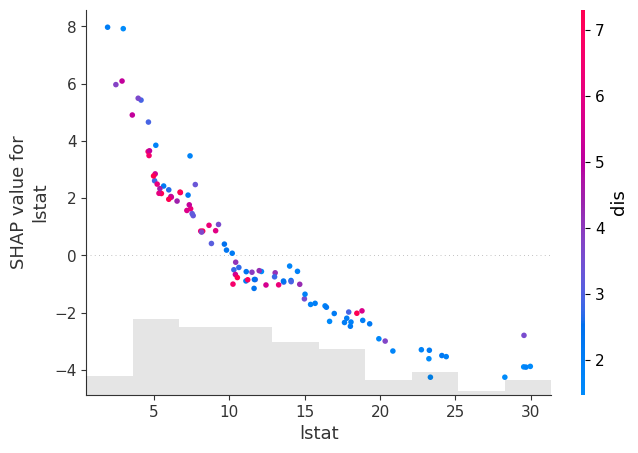

In [23]:
shap.plots.scatter(shap_values[:, "lstat"], color=shap_values)

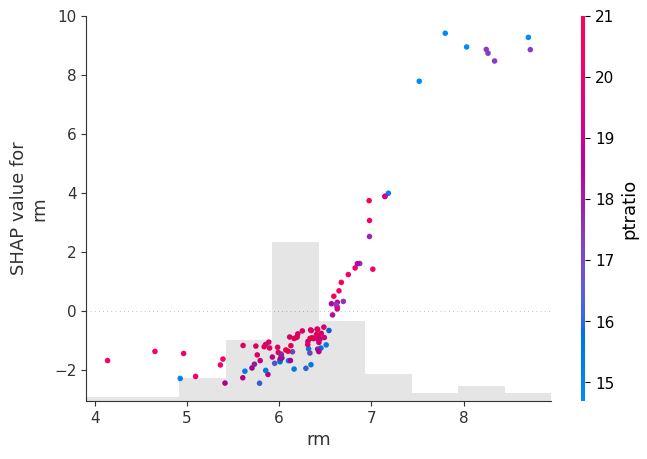

In [24]:
shap.plots.scatter(shap_values[:, "rm"], color=shap_values)

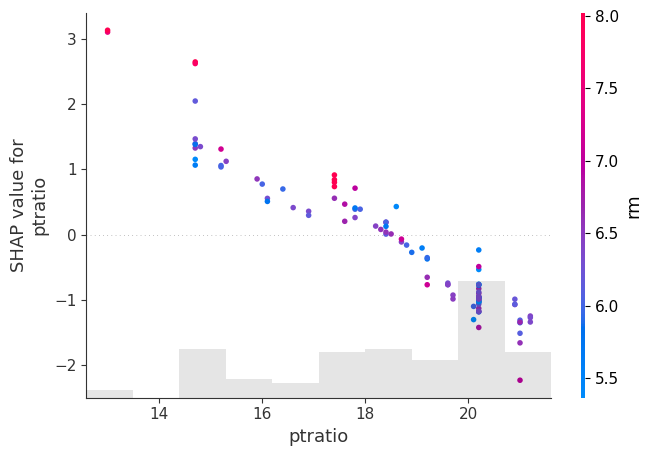

In [25]:
shap.plots.scatter(shap_values[:, "ptratio"], color=shap_values)

### Local Interpretability

The example of the `SAMPLE_IND` individual. The specific value of the `SAMPLE_IND` may be seen in the [`src\faa_p2\config.py`](src\faa_p2\config.py)

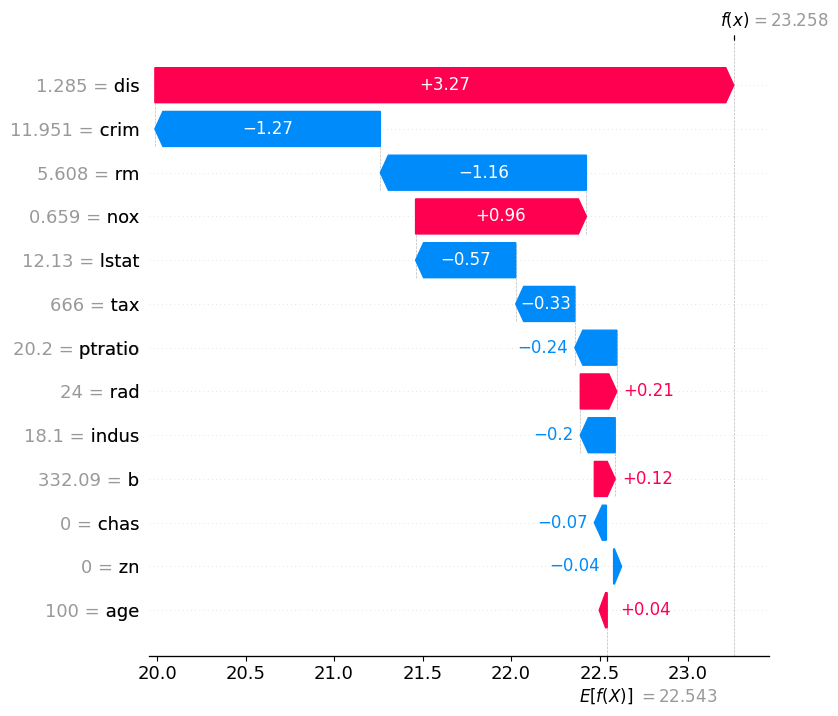

In [26]:
shap.plots.waterfall(shap_values[SAMPLE_IND], max_display=14)

## LIME

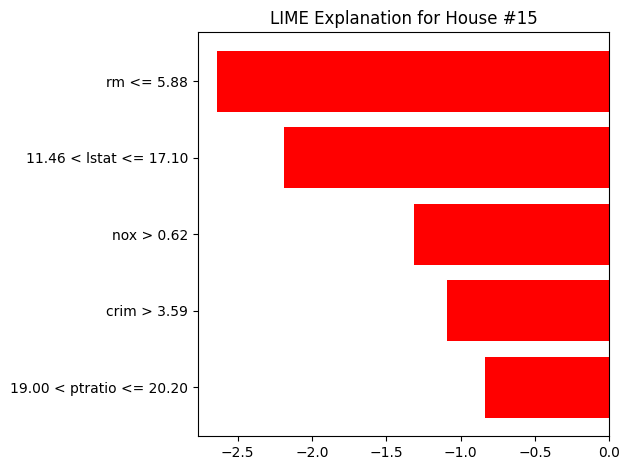

In [28]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=x_train.values,
    feature_names=x_train.columns,
    class_names=['medv'],
    mode='regression'
)

# Local Interpretability (Prediction for SAMPLE_IND = 15)
instance_index = 15
instance_to_explain = x_test.iloc[SAMPLE_IND]

exp = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=model.predict,
    num_features=5
)

fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for House #{SAMPLE_IND}")
plt.tight_layout()
plt.show()

In [32]:
print(f"Predicted Price: {model.predict([instance_to_explain])[0]:.2f}")
print("Feature Contributions:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

Predicted Price: 23.26
Feature Contributions:
rm <= 5.88: -2.6378
11.46 < lstat <= 17.10: -2.1880
nox > 0.62: -1.3128
crim > 3.59: -1.0913
19.00 < ptratio <= 20.20: -0.8384


## Permutation Importance 

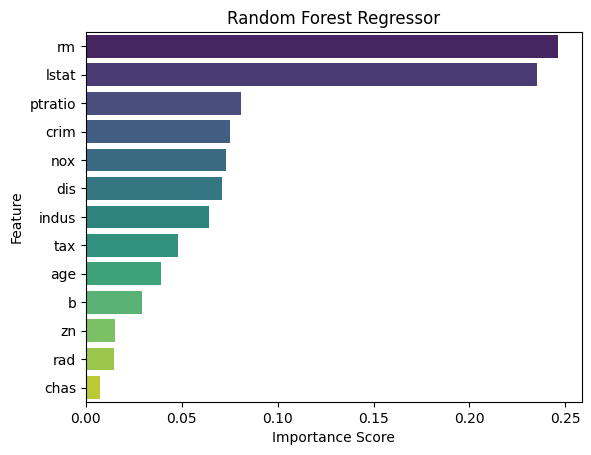

In [36]:
import seaborn as sns

importances = model.feature_importances_
feature_names = x_train.columns.tolist()


df_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})

df_imp["Abs_Importance"] = df_imp["Importance"].abs()
df_imp = df_imp.sort_values(by="Abs_Importance", ascending=False)

sns.barplot(data=df_imp, x="Importance", y="Feature", palette="viridis")

plt.title(f"{MODELS[RFR]['name']}")
plt.xlabel("Importance Score")
plt.show()

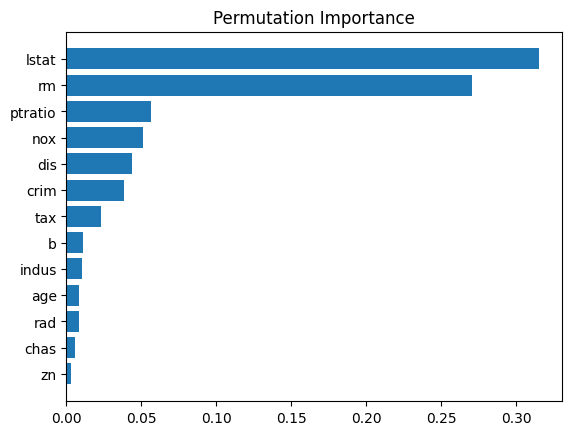

In [37]:
from sklearn.inspection import permutation_importance

# This shuffles one feature at a time and sees how much the R² drops
perm_importance = permutation_importance(model, x_test, y_test, n_repeats=10, random_state=42)

# Sort and plot
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(x.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Permutation Importance")
plt.show()

## Partial Dependence Plots (PDP)